# Lab-04 GAN

Please run the code with "VScode-devcontainer".  
It is easier to use Git in local.

> You can find the tutorial provided by Visual Studio Code here :   
> [https://code.visualstudio.com/docs/devcontainers/containers](https://code.visualstudio.com/docs/devcontainers/containers)

## Import Required Libraries

In [45]:
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchinfo import summary
from tqdm import tqdm

import matplotlib.pyplot as plt
import wandb  # for logging

## Prepare Dataset

Reference :  

- Dataset : FASHION-MNIST ( Shape : size * 28 * 28 )
    - [https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)

In [46]:
def get_dataset(root="./data", train=True):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )

    dataset = datasets.FashionMNIST(root=root, train=train, download=True, transform=transform)

    if train:
        print(f"Train dataset : {dataset.data.shape}")
    else:
        print(f"Test  dataset : {dataset.data.shape}")

    return dataset


def get_data_loader(dataset, batch_size):
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    return data_loader

## Model Implementation

- GAN
- DCGAN
- WGAN

In [47]:
# Build GAN
class Generator(torch.nn.Module):
    def __init__(self, z=100):
        super(Generator, self).__init__()

        self.z = z

        self.layers = nn.Sequential(
            nn.Linear(self.z, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.view(-1, 28, 28)

        return x


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.layers(x)

        return x

In [48]:
# Build DCGAN
class DCGenerator(torch.nn.Module):
    # ...
    pass


class DCDiscriminator(torch.nn.Module):
    # ...
    pass

In [49]:
# Build DCGAN
class WGenerator(torch.nn.Module):
    # ...
    pass


class WDiscriminator(torch.nn.Module):
    # ...
    pass

In [50]:
class Model:
    def __init__(self, name, loss_func_name, device):
        super(Model, self).__init__()

        self.name = name
        self.device = device

        if loss_func_name == "BCE":
            self.loss_func = nn.BCELoss()

        if self.name == "GAN":
            self.Gen = Generator()
            self.Dis = Discriminator()

    def summary(self):
        self.Gen = self.Gen.to(self.device)
        Gen_summary = summary(self.Gen, input_size=(1, 100), device=self.device)

        self.Dis = self.Dis.to(self.device)
        Dis_summary = summary(self.Dis, input_size=(1, 28, 28), device=self.device)

        return Gen_summary, Dis_summary

In [51]:
class Optimizer:
    def __init__(self, model: Model, name: str, learning_rate=0.001, momentum=0.9, weight_decay=0.00001):
        super(Optimizer, self).__init__()

        self.name = name

        if self.name == "SGD":
            self.Gen = optim.SGD(model.Gen.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
            self.Dis = optim.SGD(model.Dis.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        elif self.name == "Adam":
            self.Gen = optim.Adam(model.Gen.parameters(), lr=learning_rate, weight_decay=weight_decay)
            self.Dis = optim.Adam(model.Dis.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Define Function

In [52]:
def train(model: Model, train_dataloader, optimizer: Optimizer, epoch, batch_size, device):
    model.Gen.train()
    model.Dis.train()

    for e in range(epoch):
        num_data = 0
        total_loss_Gen = 0
        total_loss_Dis = 0

        for batch_idx, (data, _) in enumerate(tqdm(train_dataloader)):
            # Reshape data
            real_data = data.view(batch_size, -1).to(device)
            
            real_target = torch.ones(data.shape[0], 1).to(device)
            fake_target = torch.zeros(data.shape[0], 1).to(device)

            # Train Discriminator
            fake_data = model.Gen(torch.randn(data.shape[0], 100).to(device))
            real_output = model.Dis(real_data)
            fake_output = model.Dis(fake_data)

            loss_real_Dis = model.loss_func(real_output, real_target)
            loss_fake_Dis = model.loss_func(fake_output, fake_target)
            loss_Dis = loss_real_Dis + loss_fake_Dis
            optimizer.Dis.zero_grad()
            loss_Dis.backward()
            optimizer.Dis.step()

            # Train Generator
            fake_data = model.Gen(torch.randn(data.shape[0], 100).to(device))
            fake_output = model.Dis(fake_data)

            loss_Gen = model.loss_func(fake_output, real_target)
            optimizer.Gen.zero_grad()
            optimizer.Dis.zero_grad()
            loss_Gen.backward()
            optimizer.Gen.step()

            # log
            num_data += real_data.size(0)
            total_loss_Gen += loss_Gen.item()
            total_loss_Dis += loss_Dis.item()

        print(f"Epoch: {str(e + 1).rjust(2)}, Loss Gen: {(total_loss_Gen / num_data):.5f}, Loss Dis: {(total_loss_Dis / num_data):.5f}")

In [53]:
# define test function
def test(model: Model, test_dataloader, device):
    model.Gen.eval()
    model.Dis.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_dataloader:
            # prepare data and target
            # forward model
            # calculate loss
            # get the index of the max log-probability
            # calculate correct
            pass

In [54]:
def evaluate(model: Model, size, device):
    model.Gen.eval()
    model.Dis.eval()

    with torch.no_grad():
        data = model.Gen(torch.randn(np.square(size), 100).to(device)).cpu()
        grid = torchvision.utils.make_grid(data.view(data.shape[0], 1, 28, 28), nrow=size, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.show()

---

---

## Define Hyper-Parameters

In [78]:
UUID = 1
MODEL_NAME = "GAN"
LOSS_FUNCTION_NAME = "BCE"
OPTIMIZER_NAME = "Adam"

BATCH_SIZE = 64
EPOCH = 30

LEARNING_RATE = 0.00002
MOMENTUM = 0.9

## Get Device

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Get model

In [57]:
model = Model(name=MODEL_NAME, loss_func_name=LOSS_FUNCTION_NAME, device=device)
Gen_summary, Dis_summary = model.summary()

In [58]:
Gen_summary

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 28, 28]               --
├─Sequential: 1-1                        [1, 784]                  --
│    └─Linear: 2-1                       [1, 256]                  25,856
│    └─LeakyReLU: 2-2                    [1, 256]                  --
│    └─Linear: 2-3                       [1, 512]                  131,584
│    └─LeakyReLU: 2-4                    [1, 512]                  --
│    └─Linear: 2-5                       [1, 784]                  402,192
│    └─Tanh: 2-6                         [1, 784]                  --
Total params: 559,632
Trainable params: 559,632
Non-trainable params: 0
Total mult-adds (M): 0.56
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.24
Estimated Total Size (MB): 2.25

In [59]:
Dis_summary

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 512]                  401,920
│    └─LeakyReLU: 2-2                    [1, 512]                  --
│    └─Linear: 2-3                       [1, 256]                  131,328
│    └─LeakyReLU: 2-4                    [1, 256]                  --
│    └─Linear: 2-5                       [1, 1]                    257
│    └─Sigmoid: 2-6                      [1, 1]                    --
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
Total mult-adds (M): 0.53
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.13
Estimated Total Size (MB): 2.14

## Get Data Loader

In [60]:
train_dataloader = get_data_loader(get_dataset(train=True), batch_size=BATCH_SIZE)
test_dataloader = get_data_loader(get_dataset(train=False), batch_size=BATCH_SIZE)

Train dataset : torch.Size([60000, 28, 28])
Test  dataset : torch.Size([10000, 28, 28])


## Get Optimizer

In [61]:
optimizer = Optimizer(model=model, name=OPTIMIZER_NAME, learning_rate=LEARNING_RATE, momentum=MOMENTUM)

## Version Control

In [79]:
config = {
    "UUID": UUID,
    "architecture": MODEL_NAME,
    "epochs": EPOCH,
    "batch_size": BATCH_SIZE,
    "learning_rate": LEARNING_RATE,
    "dataset": "Fashion-MNIST",
    "optimizer": OPTIMIZER_NAME,
    "loss_function": LOSS_FUNCTION_NAME,
    "device": device.type,
}

print(config)

{'UUID': 1, 'architecture': 'GAN', 'epochs': 30, 'batch_size': 64, 'learning_rate': 2e-05, 'dataset': 'Fashion-MNIST', 'optimizer': 'Adam', 'loss_function': 'BCE', 'device': 'cuda'}


In [73]:
train(model=model, train_dataloader=train_dataloader, optimizer=optimizer, epoch=EPOCH, batch_size=BATCH_SIZE, device=device)

100%|██████████| 938/938 [00:03<00:00, 258.14it/s]


Epoch:  1, Loss Gen: 0.02761, Loss Dis: 0.01251


100%|██████████| 938/938 [00:03<00:00, 257.42it/s]


Epoch:  2, Loss Gen: 0.02771, Loss Dis: 0.01256


100%|██████████| 938/938 [00:03<00:00, 254.93it/s]


Epoch:  3, Loss Gen: 0.02686, Loss Dis: 0.01277


100%|██████████| 938/938 [00:03<00:00, 260.63it/s]


Epoch:  4, Loss Gen: 0.02700, Loss Dis: 0.01270


100%|██████████| 938/938 [00:03<00:00, 254.32it/s]


Epoch:  5, Loss Gen: 0.02673, Loss Dis: 0.01304


100%|██████████| 938/938 [00:03<00:00, 256.66it/s]


Epoch:  6, Loss Gen: 0.02720, Loss Dis: 0.01254


100%|██████████| 938/938 [00:03<00:00, 258.78it/s]


Epoch:  7, Loss Gen: 0.02700, Loss Dis: 0.01288


100%|██████████| 938/938 [00:03<00:00, 257.46it/s]


Epoch:  8, Loss Gen: 0.02691, Loss Dis: 0.01280


100%|██████████| 938/938 [00:03<00:00, 258.85it/s]


Epoch:  9, Loss Gen: 0.02594, Loss Dis: 0.01315


100%|██████████| 938/938 [00:03<00:00, 255.63it/s]

Epoch: 10, Loss Gen: 0.02509, Loss Dis: 0.01332


In [64]:
# test(model=model, test_dataloader=test_dataloader, device=device)

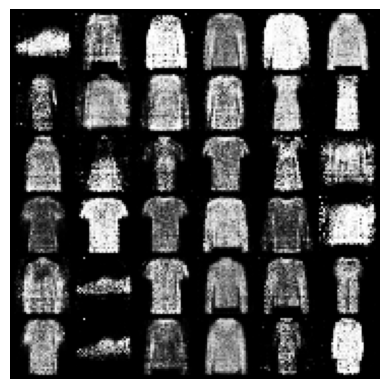

In [77]:
evaluate(model=model, size=6, device=device)